# Modelo XGBoost

In [51]:
# Importar librerías para análisis y manipulación de datos
import pandas as pd
import numpy as np

# Visualización
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Preparación de datos y partición
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Modelo XGBoost
from xgboost import XGBRegressor

# Evaluación del modelo
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, make_scorer, r2_score

In [52]:
df = pd.read_csv('/kaggle/input/viviendas-modelos/viviendas_model.csv')

In [53]:
df = df.drop([
    'Paro hombre edad < 25',
    'Paro hombre edad >=45',
    'Paro mujer edad < 25',
    'Paro mujer edad 25 -45 ',
    'Paro Agricultura',
    'Paro Industria',
    'Paro construccion',
    'Paro Servicios',
    'Paro Sin empleo Anterior',
    'Mediana de la renta por unidad de consumo',
    'Renta bruta media por persona',
    'Renta neta media por persona ',
], axis=1)


In [54]:
# La columna 'Precio' es la columna objetivo y el resto son características
X = df.drop(columns=['Precio'])
y = df['Precio']

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=101)

# Guardar los índices originales de X_test antes de escalar
X_test_indices = X_test.index

# Escalado de características
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_test_scaled_df = pd.DataFrame(X_test_scaled, index=X_test_indices, columns=X_test.columns)

In [56]:
# Definir el modelo de XGBoost
xgboost_model = XGBRegressor(objective='reg:squarederror')

In [57]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1, 0.2]
}

In [58]:
# Definir las métricas de evaluación
scoring = {
    'R2': make_scorer(r2_score),
    'neg_mean_absolute_error': make_scorer(mean_absolute_error, greater_is_better=False),
    'neg_mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False)
}

In [59]:
# Configurar la validación cruzada k-fold
kfold = KFold(n_splits=5, shuffle=True, random_state=102)

In [60]:
# Crear un KFold para la validación cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Evaluar el modelo utilizando la validación cruzada
cv_results = cross_val_score(xgboost_model, X_train_scaled, y_train, cv=kf, scoring='neg_mean_squared_error')

# Calcular la media y la desviación estándar del MSE
mean_mse = np.mean(np.abs(cv_results))
std_mse = np.std(cv_results)

print(f'Mean MSE: {mean_mse}')
print(f'Standard Deviation of MSE: {std_mse}')

Mean MSE: 89304463.6267224
Standard Deviation of MSE: 41990767.54989228


In [61]:
# Configurar la búsqueda por cuadrícula
grid_search = GridSearchCV(
    estimator=xgboost_model,
    param_grid=param_grid,
    scoring=scoring,
    refit='neg_mean_absolute_error',  # Optimizar esta métrica
    cv=kfold,
    verbose=1,
    return_train_score=True
)

In [62]:
# Ejecutar la búsqueda por cuadrícula
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=102, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    int...
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 10],
                         'n_estimators': [50, 100, 200]},
             refit='neg_mean_absolute_error', return_train_score=True,
             scoring={'R2': make_scorer(r2_score),
                      'neg_mean_absolute_error': make_scorer(mean_absolute_error, greater_is_better=False),
                      'neg_mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False)},
             verbose=1)

In [63]:
best_model = grid_search.best_estimator_

In [64]:
# Obtener los resultados y exportarlos a un CSV
results = pd.DataFrame(grid_search.cv_results_)
results.to_csv('/kaggle/working/grid_search_results.csv', index=False)

In [65]:
# Imprimir el mejor conjunto de hiperparámetros
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

Mejores hiperparámetros encontrados:
{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200}


In [66]:
# Imprimir el mejor puntaje
print("Mejor puntuación de neg_mean_absolute_error:")
print(grid_search.best_score_)

Mejor puntuación de neg_mean_absolute_error:
-2100.050822499614


In [67]:
def evaluate(model, X_test, y_test):
    predictions = model.predict(X_test)
    
    r2 = r2_score(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    
    print(f'R2: {r2}')
    print(f'MAE: {mae}')
    print(f'MSE: {mse}')
    
    # Grafica de la dispersión y la línea de regresión
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, predictions, color='blue', alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
    plt.xlabel('Valores Reales')
    plt.ylabel('Valores Predichos')
    plt.title('Valores Reales vs. Valores Predichos')
    plt.grid(True)
    plt.savefig('/kaggle/working/regression_plot.png')
    plt.show()


R2: 0.9990545485464151
MAE: 1977.7249967187295
MSE: 42295341.51054149


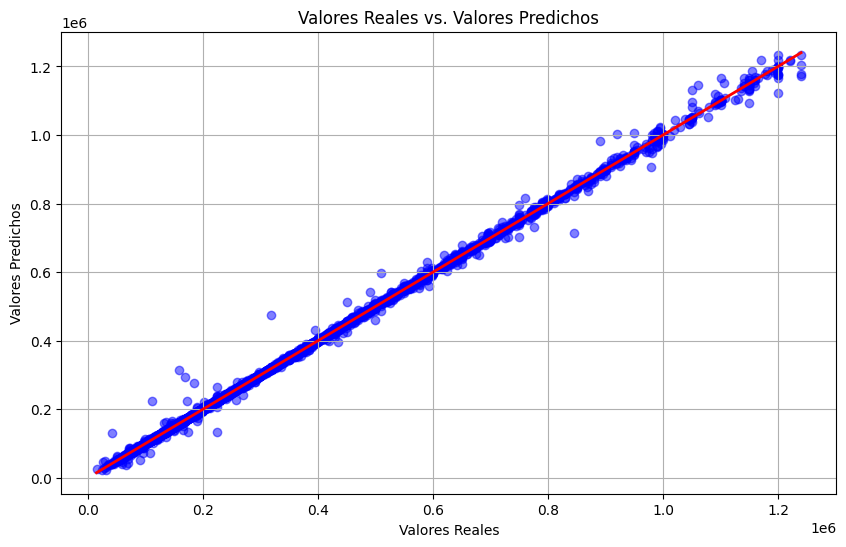

In [68]:
evaluate(best_model, X_test_scaled, y_test)

In [69]:
# Seleccionar aleatoriamente un inmueble del conjunto de prueba
random_inmueble_index = np.random.choice(X_test_indices)
random_inmueble = X_test_scaled_df.loc[random_inmueble_index].values.reshape(1, -1)
precio_predicho = best_model.predict(random_inmueble)

precio_real = y_test.loc[random_inmueble_index]

# Imprimir el precio real y el precio predicho
print(f'El precio real del inmueble seleccionado aleatoriamente es: {precio_real}')
print(f'El precio predicho del inmueble seleccionado aleatoriamente es: {precio_predicho[0]}')


El precio real del inmueble seleccionado aleatoriamente es: 85000.0
El precio predicho del inmueble seleccionado aleatoriamente es: 85469.7265625
